In [1]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd
import numpy as np
import scanpy as sc
import decoupler as dc
import pydeseq2
from pydeseq2.dds import DeseqDataSet, DefaultInference
from pydeseq2.ds import DeseqStats
import PyComplexHeatmap
import upsetplot
from upsetplot import UpSet
from upsetplot import plot
from matplotlib import pyplot as plt
import os
from pathlib import Path

sc._settings.ScanpyConfig(n_jobs=-1)

In [2]:
# Set root and output directory
REPO_ROOT = Path.cwd().resolve()
output_dir = REPO_ROOT / "figure4_outputs"
output_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Import anndata object with cell annotations and full raw count matrix
adata_path = (REPO_ROOT / "GSE290679_10069-MS_allsamples_raw_labeled_filtered.h5ad").resolve()

if not adata_path.exists():
    raise FileNotFoundError(
        f"AnnData file not found at:\n{adata_path}\n\n"
        "Download the file from GEO (GSE290679) and place it in the repository root."
    )

adata = sc.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 644147 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.ribosomal', 'percent.heme', 'percent.mt', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', 'celltype_coarse', 'celltype_fine', 'leiden', 'leiden-sub'
    uns: 'celltype_coarse_colors', 'celltype_fine_colors', 'leiden-sub_colors'
    obsm: 'X_scVI', 'X_umap'

In [4]:
# Generate pseudobulks by sample and cell type
pdata = dc.get_pseudobulk(
    adata,
    sample_col='orig.ident',
    groups_col='celltype_fine',
    mode='sum',
    min_cells=20,
    min_counts=1000,
)
pdata

AnnData object with n_obs × n_vars = 862 × 32173
    obs: 'orig.ident', 'percent_mito_filtered', 'percent_feature_filtered', 'percent_doublets', 'SCARAB_ID', 'Batch', 'Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', 'celltype_coarse', 'celltype_fine', 'psbulk_n_cells', 'psbulk_counts'
    layers: 'psbulk_props'

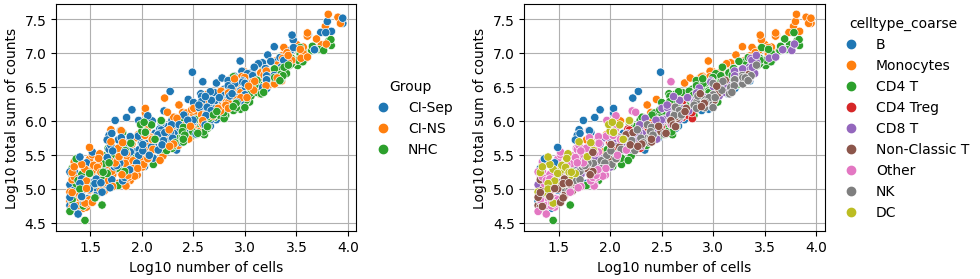

In [5]:
# Evaluate pseudobulk library sizes
dc.plot_psbulk_samples(pdata, groupby=['Group', 'celltype_coarse'], figsize=(10,3))

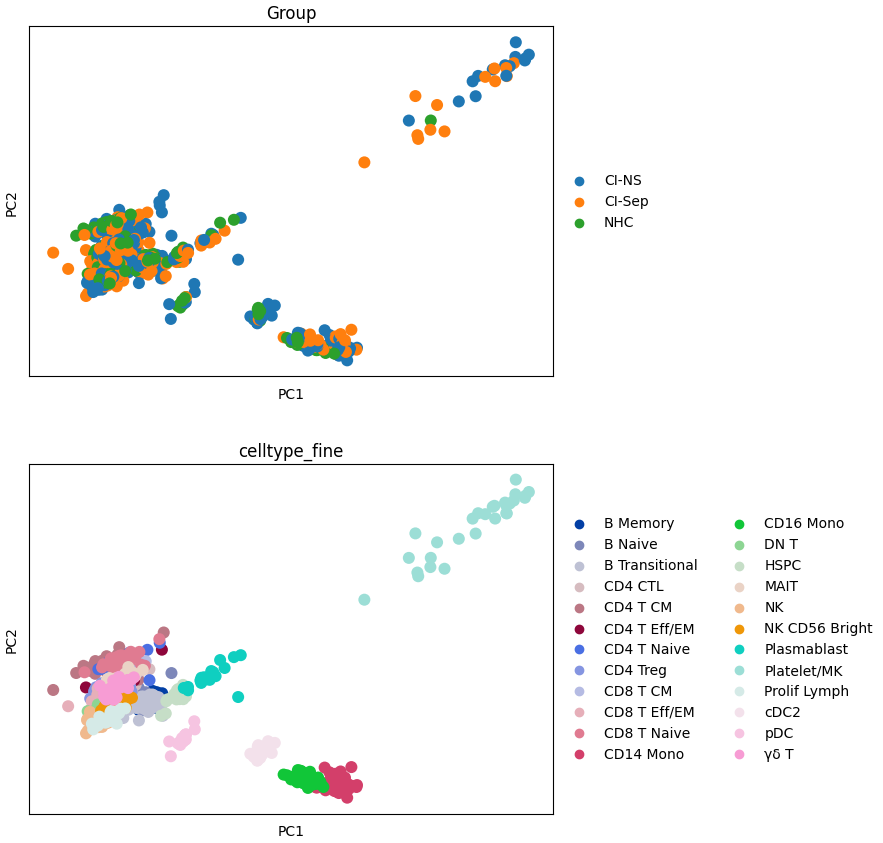

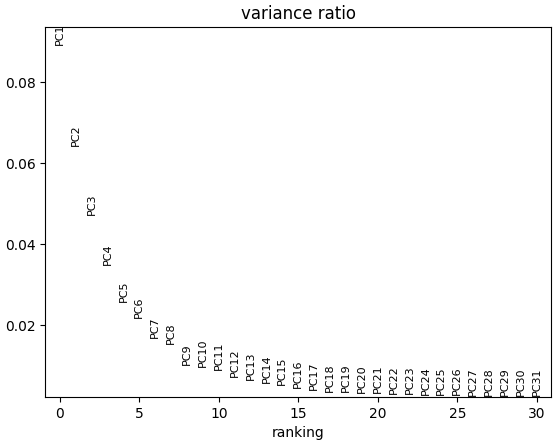

In [6]:
# PCA on pseudobulk expression to assess variance structure

# Store raw counts in layers
pdata.layers['counts'] = pdata.X.copy()

# Normalize, scale and compute pca
sc.pp.normalize_total(pdata, target_sum=1e4)
sc.pp.log1p(pdata)
sc.pp.scale(pdata, max_value=10)
sc.tl.pca(pdata)

# Return raw counts to X
dc.swap_layer(pdata, 'counts', X_layer_key=None, inplace=True)

# Plot
sc.pl.pca(pdata, color=['Group', 'celltype_fine'], ncols=1, size=300)
sc.pl.pca_variance_ratio(pdata)

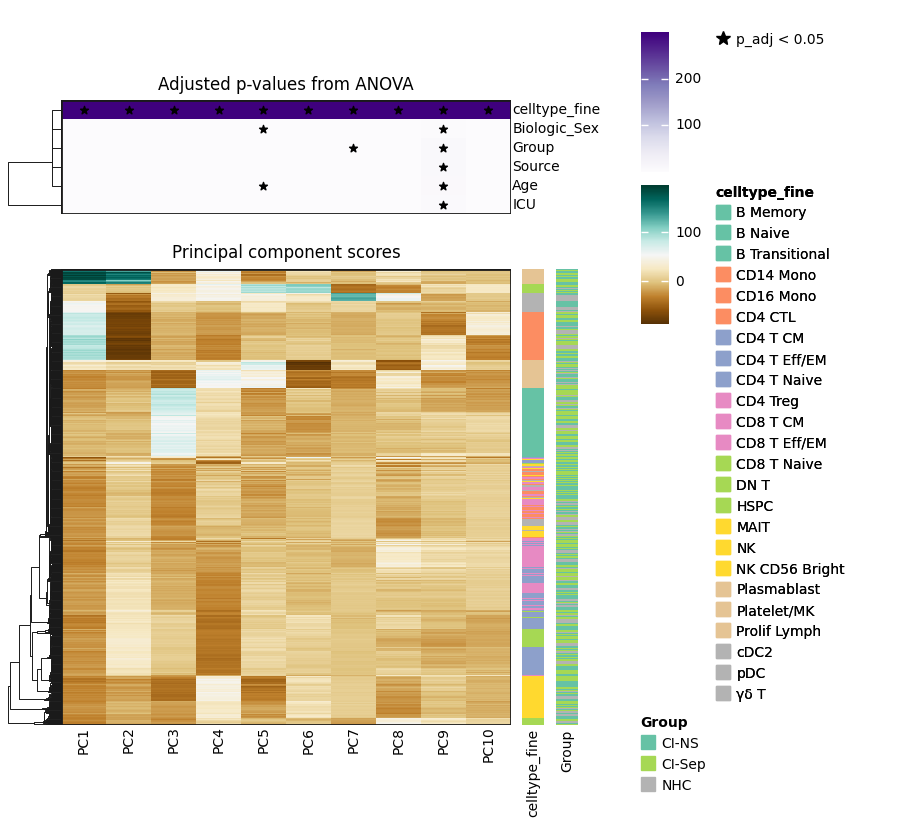

In [7]:
# Plot PC associations with metadata
dc.get_metadata_associations(
    pdata,
    obs_keys = ['Age', 'Biologic_Sex', 'ICU', 'Group', 'Source', 'celltype_fine'],
    obsm_key='X_pca',
    uns_key='pca_anova',
    inplace=True,
)

pdata.uns['pca_anova']['p_adj'] = pdata.uns['pca_anova']['p_adj'].apply(lambda x: max(x, 1e-300))

dc.plot_associations(
    pdata,
    uns_key='pca_anova',
    obsm_key='X_pca',
    stat_col='p_adj',
    obs_annotation_cols = ['celltype_fine', 'Group'],
    titles=['Principal component scores', 'Adjusted p-values from ANOVA'],
    figsize=(9, 7),
    n_factors=10
)

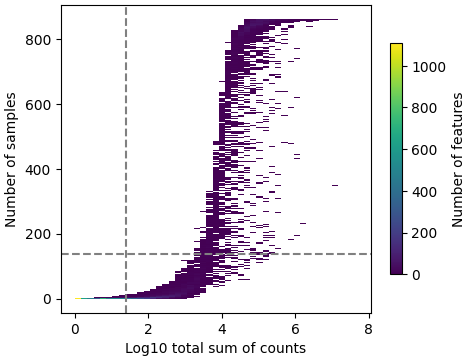

In [8]:
# Plot filtering parameters
dc.plot_filter_by_expr(pdata, 
                       group='Group', 
                       min_count=3, min_total_count=25)

In [9]:
# Run DESeq2 on pseudobulks
group_long = {
    "NHC": "NHC",
    "CINS": "CI-NS",
    "CISep": "CI-Sep"
}

celltype_map = {
    "CD4 T Naive": "Naive",
    "CD4 T Eff/EM": "EffEM",
    "CD4 Treg": "Treg",
}

contrasts = [
    ("CINS", "NHC"),
    ("CISep", "NHC"),
    ("CISep", "CINS"),
]

n_cpus = os.cpu_count()
inference = DefaultInference(n_cpus=n_cpus)

for ct_long, ct_short in celltype_map.items():
    ct_mask = pdata.obs["celltype_fine"].astype(str) == ct_long
    if ct_mask.sum() == 0:
        continue
    ad_ct = pdata[ct_mask].copy()

    for g1, g0 in contrasts:
        g1_long, g0_long = group_long[g1], group_long[g0]

        ad = ad_ct[ad_ct.obs["Group"].isin([g1_long, g0_long])].copy()
        if ad.n_obs < 2:
            continue

        genes = dc.filter_by_expr(ad, group="Group", min_count=3, min_total_count=25)
        if genes is None or len(genes) == 0:
            continue
        ad = ad[:, genes].copy()

        dds = DeseqDataSet(
            adata=ad,
            design_factors="Group",
            ref_level=["Group", g0_long],
            refit_cooks=True,
        )
        dds.deseq2()

        stat_res = DeseqStats(
            dds,
            contrast=["Group", g1_long, g0_long],
            inference=inference,
        )
        stat_res.summary()
        results_df = stat_res.results_df

        results_df.to_csv(output_dir / f"{g1}-vs-{g0}_{ct_short}.csv", index=True)

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 3.27 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 3.35 seconds.

Fitting LFCs...
... done in 0.64 seconds.

Refitting 18 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.56 seconds.



Log2 fold change & Wald test p-value: Group CI-NS vs NHC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       123.442848        0.357368  0.171349  2.085618  0.037013  0.146036
A1BG-AS1    26.011080        0.054514  0.140367  0.388367  0.697744  0.842624
A2M         26.402754        0.639868  0.274304  2.332698  0.019664  0.095128
A2M-AS1      4.200431        0.595066  0.327848  1.815065  0.069514  0.219021
A2ML1-AS1    6.273327       -0.101774  0.254380 -0.400085  0.689094  0.837248
...               ...             ...       ...       ...       ...       ...
ZXDB        48.958710        0.421747  0.086433  4.879448  0.000001  0.000068
ZXDC       145.399796       -0.044554  0.067686 -0.658238  0.510385  0.719086
ZYG11B      82.732628       -0.008269  0.061771 -0.133858  0.893515  0.952013
ZYX        622.779968        0.150040  0.089940  1.668221  0.095272  0.268937
ZZEF1      176.630722        0.218854  0.082477  2.653521  0.007966  0.051576

[14484

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.19 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 3.25 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Refitting 32 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.53 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group CI-Sep vs NHC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       112.116020        0.439907  0.322632  1.363496  0.172726  0.300895
A1BG-AS1    21.199999       -0.051575  0.294403 -0.175184  0.860935  0.915271
A2M         25.358221        0.957153  0.301549  3.174120  0.001503  0.007173
A2M-AS1      5.708328        0.927715  0.337451  2.749183  0.005974  0.021895
A2ML1-AS1    5.342357       -0.202604  0.234824 -0.862792  0.388252  0.540135
...               ...             ...       ...       ...       ...       ...
ZXDB        43.585114        0.410754  0.123215  3.333628  0.000857  0.004542
ZXDC       133.357346       -0.020185  0.057355 -0.351929  0.724892  0.821799
ZYG11B      72.786537       -0.025716  0.066005 -0.389605  0.696829  0.801374
ZYX        552.716064        0.178679  0.082428  2.167704  0.030181  0.079053
ZZEF1      163.125610        0.234869  0.072684  3.231385  0.001232  0.006079

[1356

Fitting dispersions...
... done in 3.08 seconds.

Fitting dispersion trend curve...
... done in 0.33 seconds.

Fitting MAP dispersions...
... done in 3.16 seconds.

Fitting LFCs...
... done in 0.60 seconds.

Refitting 25 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.

Running Wald tests...
... done in 0.51 seconds.

Fitting size factors...


Log2 fold change & Wald test p-value: Group CI-Sep vs CI-NS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG        78.418556        0.065108  0.243254  0.267656  0.788964  0.955003
A1BG-AS1    14.580426       -0.134504  0.226293 -0.594378  0.552259  0.877955
A2M         18.536137        0.302067  0.260874  1.157904  0.246903  0.721615
A2M-AS1      3.592900        0.311557  0.293860  1.060222  0.289044  0.747015
A2ML1-AS1    3.430828       -0.060027  0.221694 -0.270766  0.786571  0.955003
...               ...             ...       ...       ...       ...       ...
ZXDB        30.927362       -0.022485  0.100049 -0.224742  0.822180  0.961401
ZXDC        84.545593        0.028475  0.071421  0.398689  0.690122  0.926353
ZYG11B      47.254578       -0.024819  0.077812 -0.318965  0.749753  0.945205
ZYX        372.781464        0.028079  0.084106  0.333849  0.738493  0.941067
ZZEF1      109.495270        0.028307  0.078749  0.359458  0.719253  0.936641

[12

... done in 0.01 seconds.

Fitting dispersions...
... done in 3.39 seconds.

Fitting dispersion trend curve...
... done in 0.40 seconds.

Fitting MAP dispersions...
... done in 3.50 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Refitting 10 outliers.

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.55 seconds.

Fitting size factors...


Log2 fold change & Wald test p-value: Group CI-NS vs NHC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       163.582733        0.198414  0.141800  1.399252  0.161738  0.463642
A1BG-AS1    29.612181        0.180817  0.103114  1.753564  0.079505  0.323694
A2M         97.415810        0.064893  0.160880  0.403366  0.686679  0.881367
A2M-AS1     20.030241        0.088769  0.214498  0.413845  0.678987  0.878411
A2ML1-AS1    5.268641       -0.258424  0.287407 -0.899157  0.368569  0.682128
...               ...             ...       ...       ...       ...       ...
ZXDB        50.495014        0.382662  0.094010  4.070434  0.000047  0.002763
ZXDC       159.682175        0.159536  0.062941  2.534706  0.011254  0.110027
ZYG11B      79.848885        0.161485  0.056955  2.835315  0.004578  0.064573
ZYX        758.966858        0.006940  0.076569  0.090639  0.927779  0.976654
ZZEF1      221.674362        0.128236  0.080668  1.589678  0.111907  0.387493

[15007

... done in 0.00 seconds.

Fitting dispersions...
... done in 3.35 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 3.41 seconds.

Fitting LFCs...
... done in 0.66 seconds.

Refitting 12 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.53 seconds.



Log2 fold change & Wald test p-value: Group CI-Sep vs NHC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       123.410583        0.115518  0.271623  0.425290  0.670625  0.810191
A1BG-AS1    20.513842       -0.107614  0.242609 -0.443570  0.657353  0.800983
A2M         79.814125        0.138022  0.206534  0.668275  0.503958  0.687065
A2M-AS1     16.824381        0.191819  0.178892  1.072265  0.283601  0.484358
A2ML1-AS1    3.606590       -0.618179  0.257377 -2.401839  0.016313  0.071132
...               ...             ...       ...       ...       ...       ...
ZXDB        38.621208        0.327327  0.113889  2.874093  0.004052  0.025608
ZXDC       128.352859        0.185987  0.061092  3.044364  0.002332  0.016720
ZYG11B      63.535393        0.104877  0.070405  1.489617  0.136325  0.299155
ZYX        569.993225       -0.096151  0.079626 -1.207531  0.227228  0.418661
ZZEF1      190.861679        0.264235  0.085114  3.104464  0.001906  0.014474

[1445

Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 3.66 seconds.

Fitting dispersion trend curve...
... done in 0.35 seconds.

Fitting MAP dispersions...
... done in 4.78 seconds.

Fitting LFCs...
... done in 0.55 seconds.

Refitting 8 outliers.

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.74 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group CI-Sep vs CI-NS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       119.352951       -0.095216  0.194551 -0.489415  0.624548  0.872286
A1BG-AS1    20.110559       -0.285105  0.192593 -1.480345  0.138781  0.531435
A2M         72.674789        0.075741  0.188249  0.402346  0.687430  0.898919
A2M-AS1     15.390256        0.108283  0.197538  0.548160  0.583582  0.856289
A2ML1-AS1    3.089360       -0.444430  0.341471 -1.301517  0.193081       NaN
...               ...             ...       ...       ...       ...       ...
ZXDB        38.162884       -0.055243  0.100472 -0.549835  0.582433  0.856289
ZXDC       120.355431        0.027536  0.057759  0.476744  0.633545  0.877454
ZYG11B      59.106922       -0.049763  0.060616 -0.820965  0.411666  0.770379
ZYX        526.613464       -0.104786  0.073934 -1.417292  0.156398  0.556456
ZZEF1      174.093765        0.140453  0.081606  1.721105  0.085232  0.440968

[13

Fitting dispersions...
... done in 3.78 seconds.

Fitting dispersion trend curve...
... done in 0.29 seconds.

Fitting MAP dispersions...
... done in 3.49 seconds.

Fitting LFCs...
... done in 0.65 seconds.

Refitting 19 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.46 seconds.

Fitting size factors...
... done in 0.00 seconds.



Log2 fold change & Wald test p-value: Group CI-NS vs NHC
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       25.173010        0.293744  0.173943  1.688733  0.091271  0.451311
A1BG-AS1    4.673786        0.288669  0.286253  1.008440  0.313243  0.714808
AAAS       17.152807       -0.110192  0.120716 -0.912825  0.361335  0.746348
AACS        2.585396       -0.077855  0.398342 -0.195448  0.845043  0.962283
AAGAB      29.106508       -0.007071  0.104186 -0.067864  0.945894  0.986536
...              ...             ...       ...       ...       ...       ...
ZXDB        8.954360        0.685398  0.211864  3.235092  0.001216  0.055412
ZXDC       27.757874        0.056134  0.149634  0.375141  0.707556  0.916692
ZYG11B     15.892731       -0.149131  0.170404 -0.875162  0.381486  0.760367
ZYX       169.914444       -0.047581  0.099006 -0.480591  0.630807  0.883984
ZZEF1      42.039188        0.112888  0.117792  0.958366  0.337878  0.731034

[11392 rows x 6 co

Fitting dispersions...
... done in 3.69 seconds.

Fitting dispersion trend curve...
... done in 0.34 seconds.

Fitting MAP dispersions...
... done in 3.51 seconds.

Fitting LFCs...
... done in 0.47 seconds.

Refitting 2 outliers.

Fitting dispersions...
... done in 0.00 seconds.

Fitting MAP dispersions...
... done in 0.00 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...
... done in 0.46 seconds.

Fitting size factors...
... done in 0.01 seconds.



Log2 fold change & Wald test p-value: Group CI-Sep vs NHC
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       21.683493        0.254106  0.209831  1.211006  0.225893  0.504762
A1BG-AS1    3.816589        0.214552  0.272352  0.787776  0.430828  0.701797
A2M         2.828206        1.041622  0.461729  2.255915  0.024076  0.145573
AAAS       14.424650       -0.301300  0.128352 -2.347456  0.018902  0.125409
AACS        2.432524       -0.199946  0.393968 -0.507519  0.611791  0.822244
...              ...             ...       ...       ...       ...       ...
ZXDB        5.912317        0.357716  0.229891  1.556024  0.119702  0.365822
ZXDC       25.323141        0.019421  0.156332  0.124227  0.901136  0.964511
ZYG11B     13.683648       -0.081174  0.150216 -0.540381  0.588934  0.810509
ZYX       154.653473       -0.022952  0.095050 -0.241473  0.809188  0.924747
ZZEF1      37.201607        0.135661  0.118856  1.141387  0.253709  0.536583

[11186 rows x 6 c

Fitting dispersions...
... done in 3.39 seconds.

Fitting dispersion trend curve...
... done in 0.36 seconds.

Fitting MAP dispersions...
... done in 3.35 seconds.

Fitting LFCs...
... done in 0.58 seconds.

Refitting 16 outliers.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.00 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: Group CI-Sep vs CI-NS
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       21.723480       -0.042146  0.189481 -0.222426  0.823983  0.989233
A1BG-AS1    3.928429       -0.097228  0.257383 -0.377757  0.705611  0.979334
AAAS       12.981530       -0.183792  0.116726 -1.574563  0.115357  0.761079
AAGAB      23.759357        0.023778  0.100589  0.236387  0.813132  0.988785
AAK1       99.792847       -0.077675  0.087786 -0.884827  0.376250  0.907223
...              ...             ...       ...       ...       ...       ...
ZXDB        7.261238       -0.349707  0.194340 -1.799463  0.071945  0.679676
ZXDC       23.415104       -0.028787  0.139844 -0.205847  0.836910  0.990840
ZYG11B     12.633315        0.085706  0.136514  0.627820  0.530122  0.946397
ZYX       140.946579        0.029576  0.084414  0.350370  0.726061  0.979868
ZZEF1      35.928211        0.024210  0.109321  0.221462  0.824733  0.989308

[10484 rows x 6

... done in 0.44 seconds.

